In [175]:
## import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
import sympy as sy
from sklearn.metrics import r2_score
pd.set_option("display.max_rows", None)

In [176]:
import os 
input1='/Users/HP/Documents/하이웍스 받은파일/data/env'
# os.listdir(input1)
S20env=pd.read_csv('env/CT_20S.csv', usecols=[0,1,3,4])#['Pyrano_Wsec_1','Temp_Avg','Humid_Avg'])
S21env=pd.read_csv('env/CT_21S.csv', usecols=[0,2,3,4])#['Pyrano_Wsec_2','Temp_Avg','Humid_Avg'])
W20env=pd.read_csv('env/CT_20W.csv', usecols=[0,1,3,4])#['Pyrano_Wsec_1','Temp_Avg','Humid_Avg']) # 온습도 데이터 이상 
W21env=pd.read_csv('env/CT_21W.csv', usecols=[0,2,3,4])#['Pyrano_Wsec_2','Temp_Avg','Humid_Avg'])

# W20env.plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

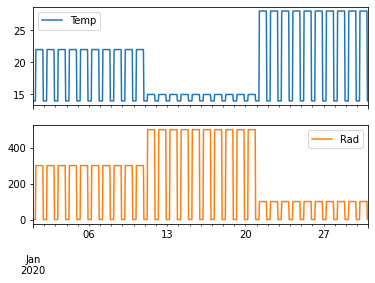

In [177]:
time_period=24*30
time=pd.date_range('2020-01-01 0:0:0',periods=time_period, freq="H")
df= pd.DataFrame(None, index = time)

DOY=df.index.strftime('%j').astype(int)

sunrise = 6
sunset = 21
df['day_night'] = df.index.hour.map(lambda h: 'day' if sunrise <= h <= sunset else 'night' )

df.loc[(df['day_night'] == 'day') , 'Temp'] = 22
df.loc[(df['day_night'] == 'night') , 'Temp'] = 14
df.loc[(df['day_night'] == 'day') & ((DOY  <= 20) &(DOY >10)), 'Temp'] = 15
df.loc[(df['day_night'] == 'day') & (20< DOY ), 'Temp'] = 28

df.loc[(df['day_night'] == 'day') & (DOY <= 10), 'Rad'] = 300
df.loc[(df['day_night'] == 'day') & ((DOY  <= 20) &(DOY >10)), 'Rad'] = 500
df.loc[(df['day_night'] == 'day') & (20< DOY ), 'Rad'] = 100
df= df.fillna(0)

df.plot(subplots=True) #.iloc[:24*6*5,:]

In [84]:
def day_time_length(df):
    radiation_threshold = 100
    daytime_length = 0
    df_day= df.resample('1D').mean()
    for i in range(len(df)):
        if df.iloc[i]['Rad'] > radiation_threshold:
            if i > 0 and df.iloc[i-1]['Rad'] <= radiation_threshold:
                start_time = df.index[i]
            if i < len(df)-1 and df.iloc[i+1]['Rad'] <= radiation_threshold:
                end_time = df.index[i]
                daytime_length += (end_time.hour - start_time.hour)
                df_day['day_len'] = daytime_length/len(df_day)
    return df_day['day_len']


In [210]:
W_str3= 0.05 #structure dry weight; kgDM
W_nsc3= W_str3- 0.045
W_sol = 0.002
W_starch = W_nsc3-W_sol
print(W_str,W_nsc, W_sol,W_starch)

0.05 0.005 0.002 0.0030000000000000044


In [213]:
'''
main code 
'''

#Model 1 
comp_20 = 7.32*10**(-5)
Q_10 = 2
CO2 = 400
LUE_CO2= 17*10**(-9)
con_bnd= 0.004
con_stem= 0.007
k = 0.7
Q10_resp = 2
C_resp = 3.47*10**(-7)
# W_dry = 0.2 #structure dry weight; kgDM
C_bet= 0.8 # Conversion rate from assimilate to dry matter
C_alp= 0.68 # conversion factor from carbon dioxide into sugar equivalents 
W_str1= 0.05 #structure dry weight; kgDM

#Model 2 
con_gro = 5*10**(-6)
Q10_gro =1.6
W_str2 =  0.045 #structure dry weight; kgDM
W_nsc2 = 0.05 - W_str2

#Model 3 
light_period =sunset-sunrise
W_str3= 0.045 #structure dry weight; kgDM
W_nsc3= 0.05- W_str3
W_sol = 0.002
W_starch = W_nsc3-W_sol


DAT=np.arange(0,len(df.resample('1D')))
DOY=df.index.strftime('%j').astype(int)
# LAI =  4/(1+np.exp((20-DOY) /7))
LAI = 2.5
LAI_series = pd.Series(LAI,df.index)
drymass1=[]
drymass2=[]
drymass3=[]
temp = df.Temp
rad = df.Rad
day_len_series= day_time_length(df)
sol=[]
a1 = 0
a2 =0 
p1 = 16/24


# Loop over each day in the data
for day in df.index.day.unique():
    daylen=int(day_len_series[day_len_series.index.day == day])
    # Loop over each hour of the day
    for hour in df.index.hour.unique():
        # Get the hourly value of LAI, temperature and radiation
        LAI_h = LAI_series[(LAI_series.index.day==day) & (LAI_series.index.hour==hour)].values[0]
        temp_h = df[(temp.index.day==day) & (temp.index.hour==hour)].Temp.values[0]
        rad_h = df[(rad.index.day==day) & (rad.index.hour==hour)].Rad.values[0]
        
        # Define parameters using hourly variables
        con_car = -1.32*10**(-5)*temp_h**2 +  5.94*10**(-4)* temp_h  -2.64*10**(-3)
        con_can=1/(1/con_bnd +1/con_stem + 1/con_car) 
        comp = comp_20*Q_10**((temp_h-20)/10)
        LUE= LUE_CO2*((CO2-comp)/(CO2+2*comp))
        phot_max = LUE*rad_h*con_can*(CO2-comp)/(LUE*rad_h+con_can*(CO2-comp)) # maximum assimilation rate (gC/day/m2)
        
        # Calculate the hourly photosynthesis and respiration
        phot = phot_max*(1-np.exp(-k*LAI_h)) # assimilate production (sugar equivalents)
               
        #Dry weight 1 
        main_resp1 = C_resp*W_str1*Q10_resp**((temp_h-25)/10) # respiration rate (kgC/hr)
        dW_dt = C_bet*(C_alp*phot - main_resp1) # rate of change of dry matter (kgDM/hr)
        W_str1 += dW_dt
        W_dry1 = W_str1
        
        #Dry weight 2
        r_gro2= con_gro*(W_nsc2/( W_nsc2+ W_str2))*Q10_gro**((temp_h-20)/10)
        main_resp2 = C_resp*W_str2*Q10_resp**((temp_h-25)/10)
        str_gro2 = r_gro2*W_str2
        gro_resp2= (1-C_bet)*str_gro2/C_bet
        
        dW_nsc_dt = C_alp*phot - main_resp2 - str_gro2 - gro_resp2  # rate of change of dry matter (kgDM/hr)
        dW_str_dt = str_gro2

        W_nsc2 +=  dW_nsc_dt
        W_str2 +=  dW_str_dt
        W_dry2 = W_str2 + W_nsc2
        
        #Dry weight 3
        r_gro3= con_gro*(W_nsc3/( W_nsc3+ W_str3))*Q10_gro**((temp_h-20)/10)
        str_gro3 = r_gro3*W_str3
        main_resp3 = C_resp*W_str3*Q10_resp**((temp_h-25)/10) # respiration rate (kgC/hr)
        gro_resp3= (1-C_bet)*str_gro3/C_bet
        
        
        dX_sol = a1+p1*phot-str_gro3-(1-a2)*main_resp3-gro_resp3
        dX_starch = -a1+(1-p1)*phot
        dW_str_dt3 = str_gro3 - a2*main_resp3
        
        W_sol += dX_sol
        W_starch += dX_starch
        W_nsc3 =  W_sol + W_starch
        W_str3 += dW_str_dt3
        W_dry3 = W_str3 + W_nsc3
      
        drymass1.append(W_dry1*1000)
        drymass2.append(W_dry2*1000)
        drymass3.append(W_dry3*1000)
        # daily_data = df.groupby(pd.Grouper(key='date', freq='D')).apply(lambda x: x.iloc[sunrise:sunset]['sugar_concentration'].mean())
        if df[(rad.index.day==day) & (rad.index.hour==hour)].day_night.values[0] =='day':
            X_sol = + dX_sol
            a1= X_sol/(24-daylen)
            a2= 1 if X_sol < W_str*0.03 else 0
            p1 = daylen/24

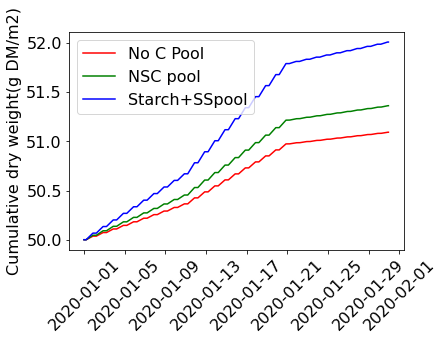

In [214]:
'''
Code plotting
'''

plt.plot(pd.Series(drymass1,df.index), 'r-',label = 'No C Pool')
plt.plot(pd.Series(drymass2,df.index), 'g-', label= 'NSC pool')
plt.plot(pd.Series(drymass3,df.index), 'b-', label = 'Starch+SSpool')
# plt.xlim(df.index[3],df.index[-1])
plt.legend()
plt.ylabel("Cumulative dry weight(g DM/m2)")
# plt.ylim(0,)
plt.xticks(rotation=45)
plt.show()

In [87]:
#산체스몰리나 2015
Temp= df.Temp.resample('1H').mean()
W_l = 
W_s = 
W_r = 
W_f = 
main_resp= 0.03*W_l + 0.015*W_s + 0.015*W_r + 0.01*W_f 
resp = main_resp*w**((Temp-25)/10)


SyntaxError: invalid syntax (1685650095.py, line 3)

------------------------------trash-----------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Q10_resp = 2     # Q10 value for respiration
C_resp = 3.47e-7 # respiration rate constant
C_bet = 0.8      # conversion rate from assimilate to dry matter
C_alp = 0.68     # conversion factor from CO2 into sugar equivalents
W_dry_str = 0.2  # structural dry weight (kgDM)

# Initialize variables
dW_dt = 0        # rate of change of dry matter
W_dry = W_dry_str  # initial dry matter
resp = 0         # initial respiration
time = [0]       # time (days)
W_dry_list = [W_dry] # dry matter list
resp_list = [resp]   # respiration list

# Simulation parameters
t_max = 100      # simulation time (days)
dt = 0.1         # time step (days)

# Simulation loop
for t in np.arange(dt, t_max, dt):
    # Calculate assimilate production (sugar equivalents)
    LUE = 0.04     # light use efficiency (gC/MJ)
    PAR = 300       # photosynthetically active radiation (MJ/day)
    CO2 = 400      # atmospheric CO2 concentration (ppm)
    LUE_CO2 = 17e-9 # CO2 effect on light use efficiency (molC/J)
    comp_20 = 7.32e-5 # compensation point at 20°C (mol/mol)
    Q10 = 2        # Q10 value for compensation point
    Temp = 25 # temperature (°C)
    
    comp = comp_20*Q10**((Temp-20)/10) # compensation point
    con_bnd = 0.004  # boundary layer conductance (mol/m2/s/Pa)
    con_stem = 0.007 # stem conductance (mol/m2/s/Pa)
    con_car = -1.32e-5*Temp**2 + 5.94e-4*Temp - 2.64e-3 # carboxylation conductance (mol/m2/s/Pa)
    con_can = 1/(1/con_bnd + 1/con_stem + 1/con_car) # total leaf conductance (mol/m2/s/Pa)
    Rad = PAR*(1-np.exp(-0.5*LAI))/(0.5*LAI) # absorbed photosynthetically active radiation (MJ/day/m2)
    phot_max = LUE*PAR*con_can*(CO2-comp)/(LUE*PAR+con_can*(CO2-comp)) # maximum assimilation rate (gC/day/m2)
    assim = C_alp*phot_max*(CO2-comp)/(LUE_CO2*(CO2+2*comp)) # assimilate production (sugar equivalents)
    
    # Calculate respiration rate
    resp = C_resp*W_dry*Q10_resp**((Temp-25)/10) # respiration rate (kgC/day)
    
    # Calculate rate of change of dry matter
    dW_dt = C_bet*(C_alp*assim - resp) # rate of change of dry matter (kgDM/day)
    
    # Update dry matter and respiration
    W_dry += dW_dt


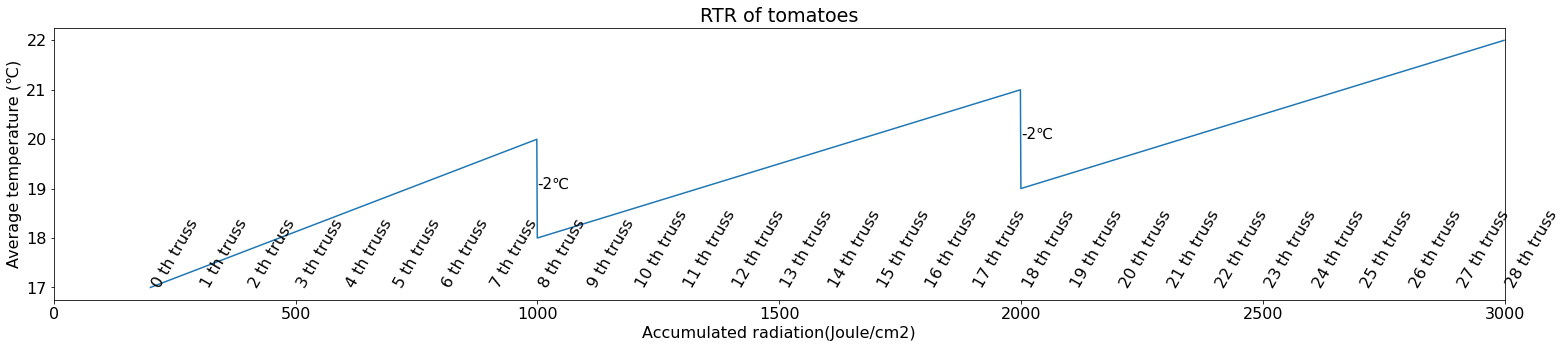

In [188]:
#imaginary RTR
li=[]
for cumrad in range(0,3000):
    if 200 <= cumrad < 1000:
        y= 3/800 *(cumrad-200) + 17 
        li.append(y)
    elif 1000<=cumrad<2000:
        y= 0.3/100 *(cumrad-1000) + 18
        li.append(y)
    elif 2000<=cumrad<3000:
        y= 0.3/100 *(cumrad-2000) + 19
        li.append(y)
    else:
        y= cumrad = None
        li.append(y)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(26, 5)) 
plt.xlim(0,3000)
plt.plot(li)
plt.xlabel("Accumulated radiation(Joule/cm2)")
plt.ylabel("Average temperature (℃)")
plt.title("RTR of tomatoes")
for i in range(199,3000,100):
    plt.text(i, 17, f'{int((i-199)/100)} th truss',rotation =60)
plt.text(1000, 19, '-2℃',fontsize = 15)
plt.text(2000, 20, '-2℃', fontsize = 15)
plt.show()

In [145]:
comp_20 = 7.32*10**(-5)
Q_10 = 2
LUE_CO2= 17*10**(-9)
con_bnd= 0.004
con_stem= 0.007
li=[]

for i in range(len(df.index)):
    comp = comp_20*Q_10**((Temp[i]-20)/10)
    LUE= LUE_CO2*((CO2-comp)/(CO2+2*comp))
    con_car = -1.32*10**(-5)*Temp[i]**2 +  5.94*10**(-4)* Temp[i]  -2.64*10**(-3)
    con_can=1/(1/con_bnd +1/con_stem + 1/con_car)
    phot_max = LUE*Rad[i]*con_can*(CO2-comp)/(LUE*Rad[i]+con_can*(CO2-comp))
    k = 0.7
    LAI=3
    phot = phot_max*(1-np.exp(-k*LAI))
    Q10_resp = 2
    C_resp = 3.47*10**(-7)
    W_dry_str = 0.2 #structure dry weight; kgDM
    C_bet= 0.8 # Conversion rate from assimilate to dry matter
    C_alp= 0.68 # conversion factor from carbon dioxide into sugar equivalents 
    dW_dt=0


    # Calculate the new value of dW based on the current value of resp
    
    resp = C_resp*np.cumsum(dW_dt)* Q10_resp**((Temp[i]-25)/10)
    # Calculate the new value of resp based on the current value of dW
    dW_dt = C_bet*(C_alp*phot-resp)
    li.append(dW_dt)
    # W_dry += dW_dt
    # Print the values of dW and resp
    # print(f"Iteration {i}: dW={dW_dt}, resp={resp}")

plt.plot(li)
plt.xticks(rotation=45)
plt.show()
# print(np.cumsum(dW_dt))

# int_func = sy.integrate(dW) + init_W

NameError: name 'Temp' is not defined